In [1]:

from bokeh.plotting import figure, show
from bokeh.palettes import Turbo256
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper
import plotly.express as px
import numpy as np
import pandas as pd
from bokeh.io import output_notebook
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

output_notebook()

def embedding_plotter(embedding, data=None, hue=None, hover=None):
    '''
    Рисовалка эмбеддинга. 2D renderer: bokeh. 3D renderer: plotly.
    '''
    if embedding.shape[1] not in [2, 3]:
        raise ValueError("Embedding must be 2D or 3D")

    plot_data = pd.DataFrame()
    plot_data['x'] = embedding[:, 0]
    plot_data['y'] = embedding[:, 1]

    if embedding.shape[1] == 3:
        plot_data['z'] = embedding[:, 2]

    if hover is not None:
        if isinstance(hover, str):
            hover = [hover]
        for col in hover:
            if data is not None:
                plot_data[col] = data[col].values

    if embedding.shape[1] == 2:
        p = figure(width=800, height=600, tools=['pan', 'box_zoom', 'reset'])

        if hue is not None and data is not None:
            # Непрерывная цветовая палитра
            color_mapper = LinearColorMapper(palette=Turbo256,
                                          low=data[hue].min(),
                                          high=data[hue].max())

            source = ColumnDataSource({
                'x': plot_data['x'],
                'y': plot_data['y'],
                'hue': data[hue]
            })

            if hover:
                for col in hover:
                    source.data[col] = data[col].values

            p.scatter('x', 'y',
                     source=source,
                     size=8,
                     color={'field': 'hue', 'transform': color_mapper},
                     alpha=0.6)

            color_bar = ColorBar(color_mapper=color_mapper,
                               label_standoff=12,
                               title=hue)
            p.add_layout(color_bar, 'right')

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                tooltips.append((hue, '@hue'))
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        else:
            p.scatter(plot_data['x'], plot_data['y'], size=8, alpha=0.6)

            if hover:
                tooltips = [(col, '@' + col) for col in hover]
                hover_tool = HoverTool(tooltips=tooltips)
                p.add_tools(hover_tool)

        show(p)

    # 3D
    else:
        if hue is not None and data is not None:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              color=data[hue],
                              hover_data=hover if hover else None)
        else:
            fig = px.scatter_3d(plot_data, x='x', y='y', z='z',
                              hover_data=hover if hover else None)

        fig.update_layout(
            width=800,
            height=600,
        )


        fig.show()
def representative_point_idx(df):
        points = df.select(pl.col("X", "Y")).to_numpy()
        median = hdm.geomedian(points, axis = 0)
        dists = np.linalg.norm(points - median, axis=1)
        return np.argmin(dists)
import sklearn.cluster as clu

from IPython.display import display, HTML

Loading BokehJS ...

To generate UMAP files from `hexanes_rwp5_constr.cor` run

``` 
 rmsd-map-distances -o hexanes_rwp5_constr hexanes_rwp5_constr.cor
 rmsd-map-umaps -o hexanes_rwp5_constr_umaps hexanes_rwp5_constr.npz
 rmsd-map-umaps -d -o hexanes_rwp5_constr_umaps_d hexanes_rwp5_constr.npz
```

In [2]:
# !rmsd-map-distances -o ./conformer/hexanes_rwp5_constr ./conformer/hexanes_rwp5_constr.cor

In [3]:
# !rmsd-map-umaps -o ./conformer/hexanes_rwp5_constr_umaps ./conformer/hexanes_rwp5_constr.npz
# !rmsd-map-umaps -d -o ./conformer/hexanes_rwp5_constr_umaps_d ./conformer/hexanes_rwp5_constr.npz

<Axes: xlabel='X', ylabel='Y'>

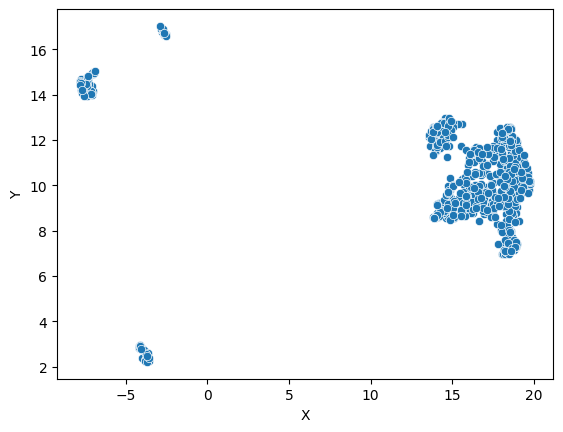

In [4]:
import rmsd_map
from rmsd_map.mol_io.cor_reader import read_cor_file
from rmsd_map.mol_io.fragment import Fragment
from rmsd_map.rmsd.pipelines import align_fragments
import numpy as np
import polars as pl
import seaborn as sns
cor = read_cor_file("./conformer/hexanes_rwp5_constr.cor")
cor = np.asarray(cor, dtype=object)
um = pl.read_csv("./conformer/hexanes_rwp5_constr_umaps.csv") # Vanilla UMAP
ud = pl.read_csv("./conformer/hexanes_rwp5_constr_umaps_d.csv") # Denity-preserving UMAP 



df = ud.filter(pl.col("N") == 30)
sns.scatterplot(data = df , x="X", y="Y")

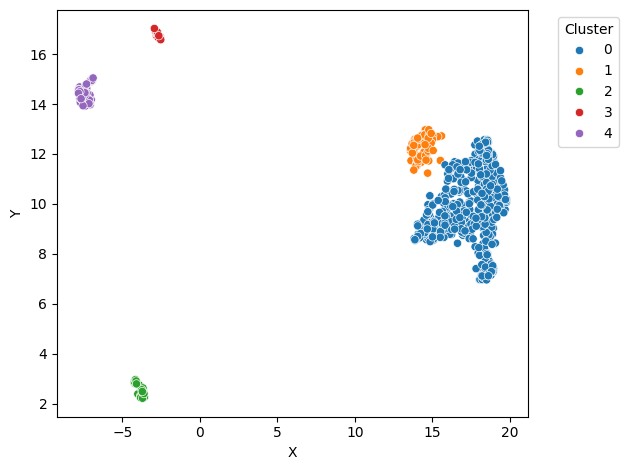

In [5]:

import sklearn.cluster as clu
import matplotlib.pyplot as plt

dbscan = clu.HDBSCAN(min_cluster_size=15,
    min_samples=5,
    cluster_selection_epsilon=0.1,
    metric='euclidean').fit(df.select(pl.col("X", "Y")).to_numpy())
df2 = df.with_columns(pl.Series("label", dbscan.labels_))

sns.scatterplot(data = df2, x = 'X', y = 'Y', hue = 'label', palette='tab10')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

def norm_vec(vec):

    vec = np.array(vec, dtype=float)
    norm_val = np.linalg.norm(vec)
    return vec / norm_val


def get_orth_norm_vec(vec, vref):

    vec = np.array(vec, dtype=float)
    vref = np.array(vref, dtype=float)
    
    # Project vec onto vref and subtract to get orthogonal component
    temp = vec - vref * np.dot(vec, vref)
    return norm_vec(temp)


def torsion_angle(a, b, c, d):

    # Convert to numpy arrays
    abcd = np.array([a, b, c, d], dtype=float)
    
    # Get three vectors:
    # b_c: normalized vector b→c
    b_c = norm_vec(abcd[2, :] - abcd[1, :])
    
    # b_a_orth: orthogonal component (normalized) of vector b→a with reference to b→c
    b_a_orth = get_orth_norm_vec(abcd[0, :] - abcd[1, :], b_c)
    
    # c_d_orth: orthogonal component (normalized) of vector c→d with reference to b→c
    c_d_orth = get_orth_norm_vec(abcd[3, :] - abcd[2, :], b_c)
    
    # Calculate the angle between the two orthogonal vectors
    dot_product = np.dot(b_a_orth, c_d_orth)
    # Clamp to [-1, 1] to avoid numerical errors in arccos
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_deg = np.arccos(dot_product) * 180 / np.pi
    
    # Determine the sign of the torsion angle
    # The sign is determined by the relative orientation of the cross product
    # of the two orthogonal vectors with reference to the middle vector b→c
    cross_product = np.cross(b_a_orth, c_d_orth)
    sign = np.dot(cross_product, b_c)
    
    if sign < 0:
        angle_deg = -angle_deg
    
    return angle_deg


abcd = np.array([
        [21.350, 31.325, 22.681],
        [22.409, 31.286, 21.483],
        [22.840, 29.751, 21.498],
        [23.543, 29.175, 22.594]
])
    
a, b, c, d = abcd[0], abcd[1], abcd[2], abcd[3]
    
result = torsion_angle(a, b, c, d)
print(f"Torsion angle: {result:.5f}°")
print(f"Expected: -65.609° (from MATLAB example)")

Torsion angle: -65.60923°
Expected: -65.609° (from MATLAB example)


In [7]:
cor[0].coords.shape

(6, 3)

In [8]:
# Function to extract carbon coordinates from a conformer
def extract_carbon_coords(conformer, order_by_chain=True):
    """
    Extract 6 carbon atom coordinates from a conformer.
    Returns array of shape (6, 3) with coordinates ordered along the chain.
    Handles both Fragment objects and string lists.
    """
    return conformer.coords

# Function to calculate all torsion angles for a hexane conformer
def calculate_hexane_torsions(coords):
    """
    Calculate torsion angles for hexane C1-C2-C3-C4-C5-C6.
    Returns list of 3 torsion angles: [C1-C2-C3-C4, C2-C3-C4-C5, C3-C4-C5-C6]
    """
    if coords is None or len(coords) < 6:
        return [np.nan, np.nan, np.nan]
    
    torsions = []
    # Calculate three torsion angles
    for i in range(3):
        p1, p2, p3, p4 = coords[i], coords[i+1], coords[i+2], coords[i+3]
        torsion = torsion_angle(p1, p2, p3, p4)
        torsions.append(torsion)
    
    return torsions

# Function to classify hexane conformer based on torsion angles
def classify_hexane_conformer(torsions, threshold=15):
    """
    Classify hexane conformer based on torsion angles.
    threshold: angle threshold in degrees to distinguish trans (~180°) from gauche (~60°)
    """
    if any(np.isnan(torsions)):
        return "Unknown"
    
    # Normalize angles to -180 to 180
    normalized = []
    for t in torsions:
        # Normalize to -180 to 180
        while t > 180:
            t -= 360
        while t < -180:
            t += 360
        normalized.append(t)
    
    # Classify each torsion
    classifications = []
    for t in normalized:
        if abs(t) > 180 - threshold:  # Trans (anti) - near ±180°
            classifications.append('t')
        elif abs(t - 60) < threshold or abs(t + 60) < threshold or abs(t - 300) < threshold or abs(t + 300) < threshold:
            classifications.append('g')  # Gauche - near ±60°
        else:
            classifications.append('m')  # Mixed/other
    
    # Create conformer type string
    conformer_type = ''.join(classifications)
    
    # Map to more readable names
    type_map = {
        'ttt': 'All-trans',
        'ttg': 'Trans-Trans-Gauche',
        'tgt': 'Trans-Gauche-Trans',
        'gtt': 'Trans-Trans-Gauche',
        'tgg': 'Trans-Gauche-Gauche',
        'gtg': 'Gauche-Trans-Gauche',
        'ggt': 'Trans-Gauche-Gauche',
        'ggg': 'All-gauche',
    }
    
    return type_map.get(conformer_type, f'Mixed-{conformer_type}')


In [9]:
# Process conformers and calculate torsion angles
# Match conformers to dataframe rows using the 'N' column as index
print(f"Processing conformers...")
print(f"Total conformers in cor: {len(cor)}")
print(f"Rows in df2: {len(df2)}")

# Check if 'N' column exists and can be used for matching
if 'N' in df2.columns:
    print(f"N column range: {df2['N'].min()} to {df2['N'].max()}")
    
# Calculate torsion angles for conformers that match df2 rows
torsion_angles_dict = {}
conformer_types_dict = {}
mean_torsion_angles_dict = {}

# Process all conformers first
for i, conformer in enumerate(cor):
    # Extract carbon coordinates
    coords = extract_carbon_coords(conformer)
    
    if coords is not None and len(coords) >= 4:  # Need at least 4 atoms for torsion
        # Calculate torsion angles
        torsions = calculate_hexane_torsions(coords)
        
        # Calculate mean torsion angle
        mean_torsion = np.nanmean([t for t in torsions if not np.isnan(t)])
        
        # Classify conformer
        conformer_type = classify_hexane_conformer(torsions)
        
        torsion_angles_dict[i] = torsions
        mean_torsion_angles_dict[i] = mean_torsion
        conformer_types_dict[i] = conformer_type
    else:
        torsion_angles_dict[i] = [np.nan, np.nan, np.nan]
        mean_torsion_angles_dict[i] = np.nan
        conformer_types_dict[i] = "Unknown"

print(f"Processed {len(torsion_angles_dict)} conformers")
print(f"Found {len([t for t in conformer_types_dict.values() if t != 'Unknown'])} valid conformers")


if 1==1:
    # Assume row index matches conformer index
    torsion_1_list = []
    torsion_2_list = []
    torsion_3_list = []
    mean_torsion_list = []
    conformer_type_list = []
    
    for i in range(len(df2)):
        torsions = torsion_angles_dict.get(i, [np.nan, np.nan, np.nan])
        torsion_1_list.append(torsions[0] if len(torsions) > 0 else np.nan)
        torsion_2_list.append(torsions[1] if len(torsions) > 1 else np.nan)
        torsion_3_list.append(torsions[2] if len(torsions) > 2 else np.nan)
        mean_torsion_list.append(mean_torsion_angles_dict.get(i, np.nan))
        conformer_type_list.append(conformer_types_dict.get(i, "Unknown"))
    
    df_with_torsions = df2.with_columns([
        pl.Series("torsion_1", torsion_1_list),
        pl.Series("torsion_2", torsion_2_list),
        pl.Series("torsion_3", torsion_3_list),
        pl.Series("mean_torsion", mean_torsion_list),
        pl.Series("conformer_type", conformer_type_list)
    ])

print(f"\nConformer type distribution:")
print(df_with_torsions.group_by("conformer_type").agg(pl.len()).sort("conformer_type"))


Processing conformers...
Total conformers in cor: 669
Rows in df2: 669
N column range: 30 to 30
Processed 669 conformers
Found 669 valid conformers

Conformer type distribution:
shape: (17, 2)
┌─────────────────────┬─────┐
│ conformer_type      ┆ len │
│ ---                 ┆ --- │
│ str                 ┆ u32 │
╞═════════════════════╪═════╡
│ All-gauche          ┆ 1   │
│ All-trans           ┆ 528 │
│ Gauche-Trans-Gauche ┆ 34  │
│ Mixed-gtm           ┆ 1   │
│ Mixed-mgt           ┆ 1   │
│ …                   ┆ …   │
│ Mixed-tmt           ┆ 7   │
│ Mixed-ttm           ┆ 4   │
│ Trans-Gauche-Gauche ┆ 3   │
│ Trans-Gauche-Trans  ┆ 19  │
│ Trans-Trans-Gauche  ┆ 42  │
└─────────────────────┴─────┘


In [10]:
df_with_torsions.filter(~pl.col("conformer_type").str.to_lowercase().str.contains("mixed"))

X,Y,N,label,torsion_1,torsion_2,torsion_3,mean_torsion,conformer_type
f64,f64,i64,i64,f64,f64,f64,f64,str
18.135141,11.83838,30,0,-179.429962,180.0,179.429625,59.999888,"""All-trans"""
18.6225,9.926744,30,0,177.3681,-179.999997,-177.368108,-60.000002,"""All-trans"""
16.252441,8.783287,30,0,175.13978,179.999694,-175.139779,59.999899,"""All-trans"""
-6.941508,14.935749,30,4,59.874997,56.557695,177.1348,97.855831,"""Trans-Gauche-Gauche"""
18.523617,8.974354,30,0,176.242174,-179.99999,-176.242164,-59.999993,"""All-trans"""
…,…,…,…,…,…,…,…,…
15.059376,12.137383,30,1,176.016857,177.374494,178.042211,177.144521,"""All-trans"""
18.033754,12.311728,30,0,-179.760224,-179.999626,179.760236,-59.999871,"""All-trans"""
16.797205,11.371173,30,0,-179.285612,180.0,179.285612,60.0,"""All-trans"""


In [11]:
df_with_torsions_good = df_with_torsions.filter(~pl.col("conformer_type").str.to_lowercase().str.contains("mixed"))
df_with_torsions_bad = df_with_torsions.filter(pl.col("conformer_type").str.to_lowercase().str.contains("mixed"))

Conformer types and their counts:
shape: (6, 2)
┌─────────────────────┬─────┐
│ conformer_type      ┆ len │
│ ---                 ┆ --- │
│ str                 ┆ u32 │
╞═════════════════════╪═════╡
│ Trans-Trans-Gauche  ┆ 42  │
│ Trans-Gauche-Trans  ┆ 19  │
│ Trans-Gauche-Gauche ┆ 3   │
│ Gauche-Trans-Gauche ┆ 34  │
│ All-trans           ┆ 528 │
│ All-gauche          ┆ 1   │
└─────────────────────┴─────┘


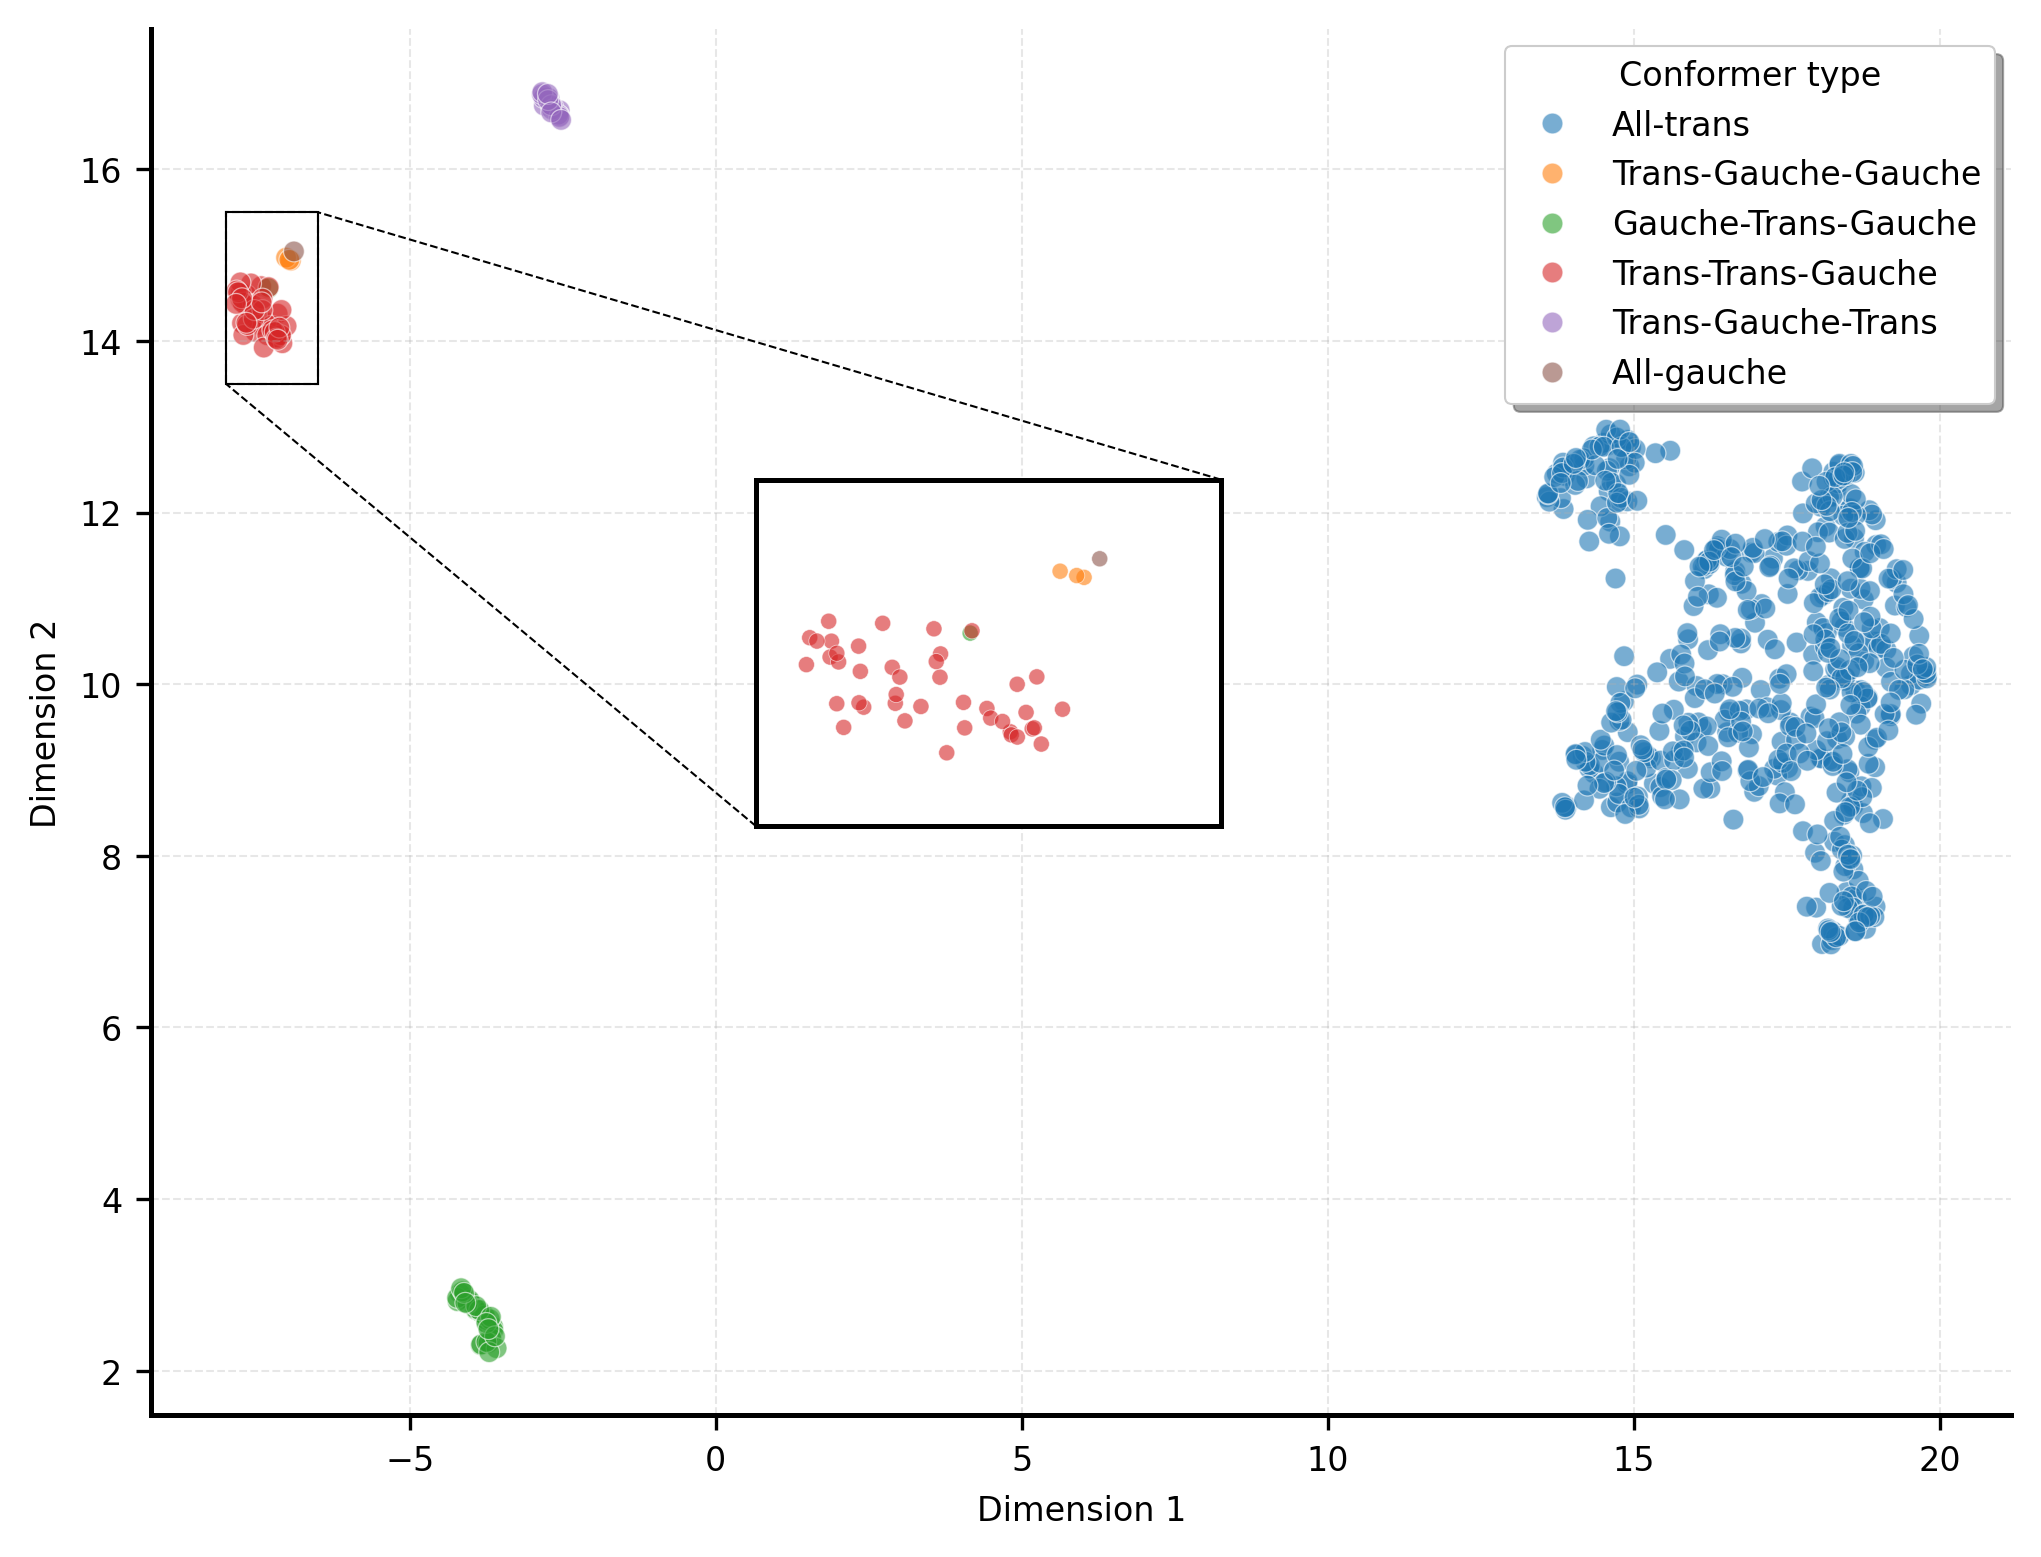

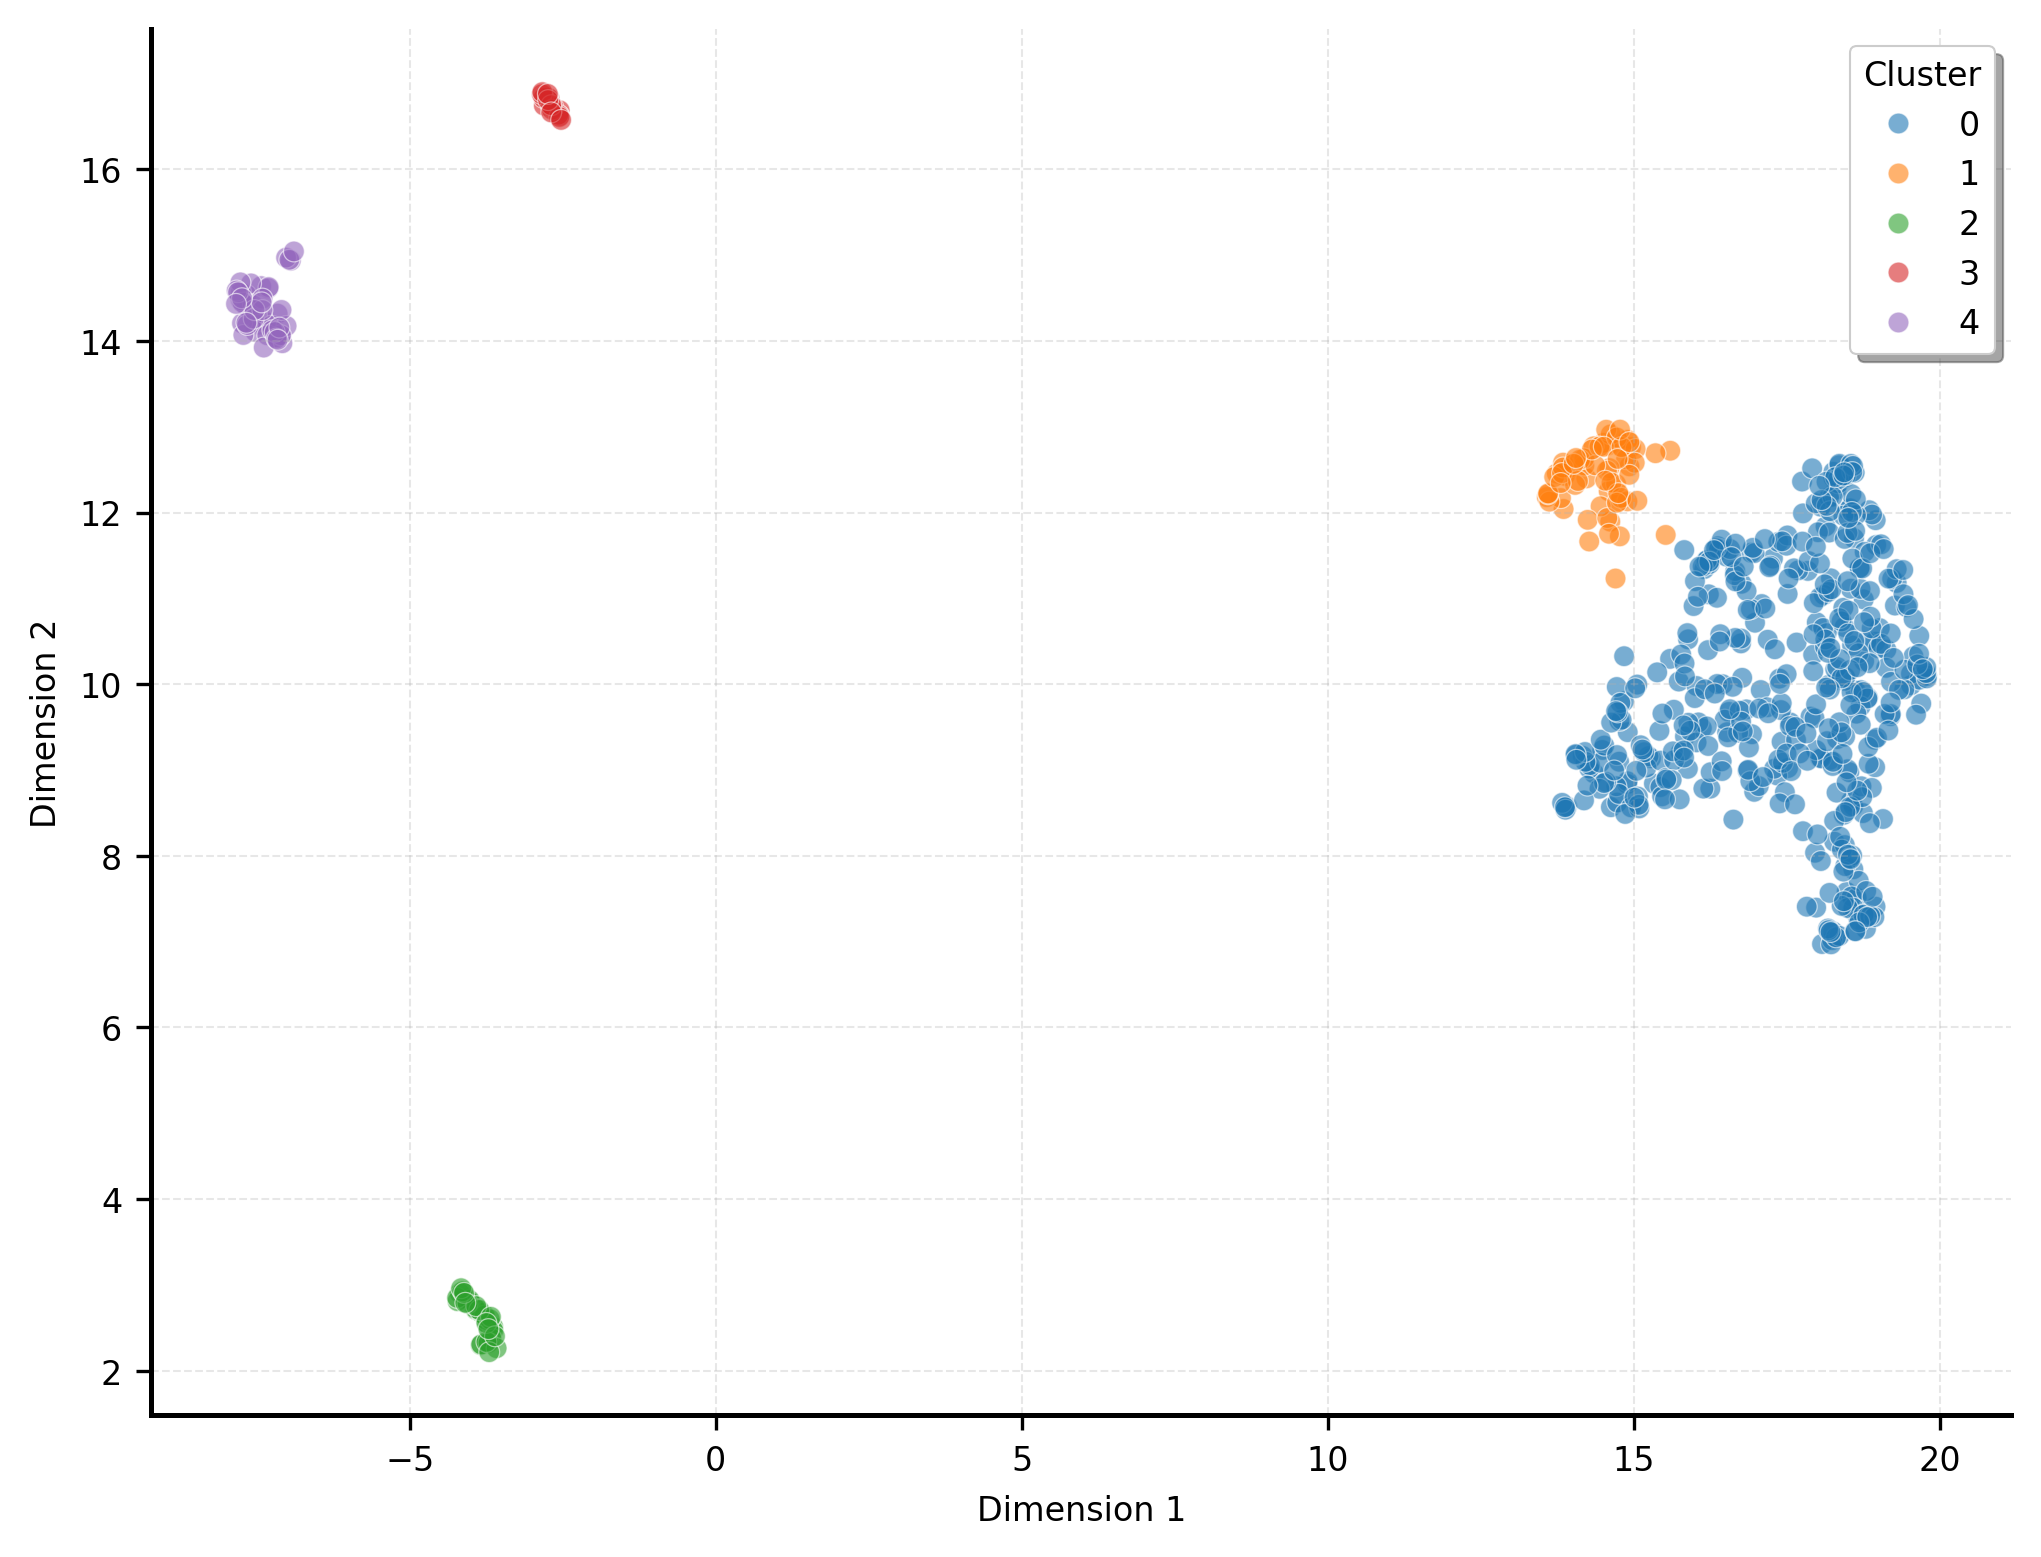

In [71]:
# Visualization 2: Scatterplot colored by conformer type
# Publication-quality styling
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-quality style
plt.rcParams.update({
    'font.size': 4,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'patch.linewidth': 0.5
})

# Filter out Unknown conformers for cleaner visualization
df_plot_type = df_with_torsions_good.filter(pl.col("conformer_type") != "Unknown")

# Count conformer types to show only those with sufficient data
type_counts = df_plot_type.group_by("conformer_type").agg(pl.len()).sort("conformer_type", descending=True)
print("Conformer types and their counts:")
print(type_counts)

# Create scatterplot with publication styling and inset zoom
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(8, 6))
df_pandas = df_plot_type.to_pandas()
sns.scatterplot(data=df_pandas, x='X', y='Y', hue='conformer_type', 
                palette='tab10', alpha=0.6, s=25, edgecolors='white', linewidth=0.3, ax=ax)
ax.set_xlabel('Dimension 1', fontsize=8, fontweight='normal')
ax.set_ylabel('Dimension 2', fontsize=8, fontweight='normal')
# ax.set_title('UMAP visualization colored by hexane conformer type', fontsize=12, fontweight='bold', pad=15)
ax.legend(title='Conformer type', 
          frameon=True, fancybox=True, shadow=True, fontsize=8, title_fontsize=8)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define zoom region
zoom_xlim = (-8, -6.5)
zoom_ylim = (13.5, 15.5)

# Mark the zoom region on the main plot with a rectangle
from matplotlib.patches import Rectangle
rect = Rectangle((zoom_xlim[0], zoom_ylim[0]), 
                zoom_xlim[1] - zoom_xlim[0], 
                zoom_ylim[1] - zoom_ylim[0],
                linewidth=0.5, edgecolor='black', facecolor='none', linestyle='-', zorder=10)
ax.add_patch(rect)

# Create inset axes for zoomed view (centered)
axins = inset_axes(ax, width="25%", height="25%", loc='center', 
                   bbox_to_anchor=(-0.05, 0.05, 1, 1), bbox_transform=ax.transAxes)
sns.scatterplot(data=df_pandas, x='X', y='Y', hue='conformer_type', 
                palette='tab10', alpha=0.6, s=15, edgecolors='white', linewidth=0.2, ax=axins)
axins.set_xlim(zoom_xlim)
axins.set_ylim(zoom_ylim)
axins.set_xlabel('', fontsize=6)
axins.set_ylabel('', fontsize=6)
# Remove ticks and grid from the inset
axins.set_xticks([])
axins.set_yticks([])
axins.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
#axins.spines['top'].set_visible(False)
#axins.spines['right'].set_visible(False)
# Remove legend from inset
axins.get_legend().remove()

# Mark the connection between main plot and inset
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="black", linestyle='--', linewidth=0.5)
plt.savefig('./final_images/umap_conformer_type.png', dpi=400)
# plt.tight_layout()
plt.show()

# Create scatterplot colored by label
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_pandas, x='X', y='Y', hue='label', 
                palette='tab10', alpha=0.6, s=25, edgecolors='white', linewidth=0.3, ax=ax)
ax.set_xlabel('Dimension 1', fontsize=8, fontweight='normal')
ax.set_ylabel('Dimension 2', fontsize=8, fontweight='normal')
# ax.set_title('UMAP visualization colored by hexane conformer type', fontsize=12, fontweight='bold', pad=15)
ax.legend(title='Cluster', 
          frameon=True, fancybox=True, shadow=True, fontsize=8, title_fontsize=8)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.tight_layout()
plt.savefig('./final_images/umap_conformer_cluster.png', dpi=400)
plt.show()


Conformer types and their counts:
shape: (6, 2)
┌─────────────────────┬───────┐
│ conformer_type      ┆ count │
│ ---                 ┆ ---   │
│ str                 ┆ u32   │
╞═════════════════════╪═══════╡
│ Trans-Trans-Gauche  ┆ 42    │
│ Trans-Gauche-Trans  ┆ 19    │
│ Trans-Gauche-Gauche ┆ 3     │
│ Gauche-Trans-Gauche ┆ 34    │
│ All-trans           ┆ 528   │
│ All-gauche          ┆ 1     │
└─────────────────────┴───────┘


/tmp/ipykernel_45925/1729077328.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  type_counts = df_plot_type.group_by("conformer_type").agg(pl.count()).sort("conformer_type", descending=True)


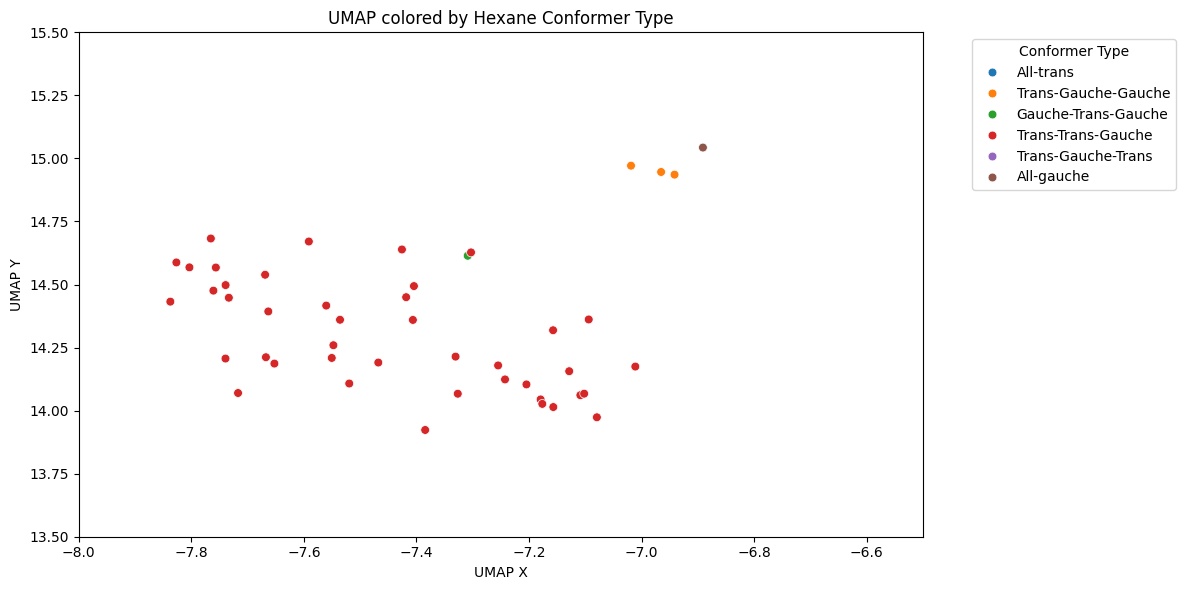

In [13]:
# Visualization 2: Scatterplot colored by conformer type
plt.figure(figsize=(12, 6))

# Filter out Unknown conformers for cleaner visualization
df_plot_type = df_with_torsions_good.filter(pl.col("conformer_type") != "Unknown")

# Count conformer types to show only those with sufficient data
type_counts = df_plot_type.group_by("conformer_type").agg(pl.count()).sort("conformer_type", descending=True)
print("Conformer types and their counts:")
print(type_counts)

# Create scatterplot
sns.scatterplot(data=df_plot_type.to_pandas(), x='X', y='Y', hue='conformer_type', 
                palette='tab10', alpha=1, s=40)
plt.title('UMAP colored by Hexane Conformer Type')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.xlim(-8, -6.5)
plt.ylim(13.5,15.5)
plt.legend(title='Conformer Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
df_with_torsions_idx = df_with_torsions.with_row_index("row_idx")
df_with_torsions_idx.filter(pl.col('conformer_type') == "Gauche-Trans-Gauche").filter(pl.col('Y') >= 13)["row_idx"]

row_idx
u32
100


In [15]:
cor[100]

Fragment(id='CUTYEY_1', elements=array(['C', 'C', 'C', 'C', 'C', 'C'], dtype='<U2'), coords=array([[ 5.94418,  5.75993, 12.23299],
       [ 4.86528,  4.96141, 12.93483],
       [ 4.75649,  3.52211, 12.47139],
       [ 4.28334,  3.33836, 11.04719],
       [ 4.39409,  1.89441, 10.55752],
       [ 5.82876,  1.47958, 10.27334]], dtype=float32))

In [16]:
clu0_aligned = align_fragments(cor[100:101], 0) # and align all fragments to it
clu0_view = Fragment.plot_fragments(clu0_aligned)
display(HTML(clu0_view.write_html(fullpage=True)))

Conformer types and their counts:
shape: (11, 2)
┌────────────────┬───────┐
│ conformer_type ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ Mixed-ttm      ┆ 4     │
│ Mixed-tmt      ┆ 7     │
│ Mixed-tmm      ┆ 3     │
│ Mixed-tmg      ┆ 1     │
│ Mixed-mtt      ┆ 4     │
│ …              ┆ …     │
│ Mixed-mtg      ┆ 1     │
│ Mixed-mmm      ┆ 5     │
│ Mixed-mmg      ┆ 3     │
│ Mixed-mgt      ┆ 1     │
│ Mixed-gtm      ┆ 1     │
└────────────────┴───────┘


/tmp/ipykernel_45925/3226136981.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  type_counts = df_plot_type.group_by("conformer_type").agg(pl.count()).sort("conformer_type", descending=True)


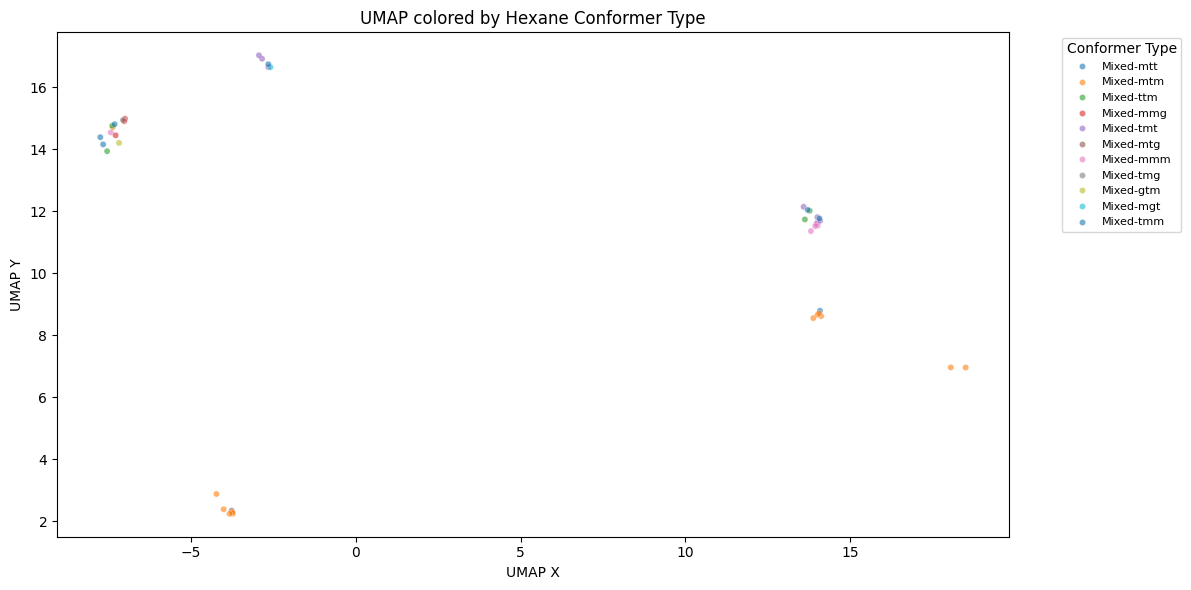

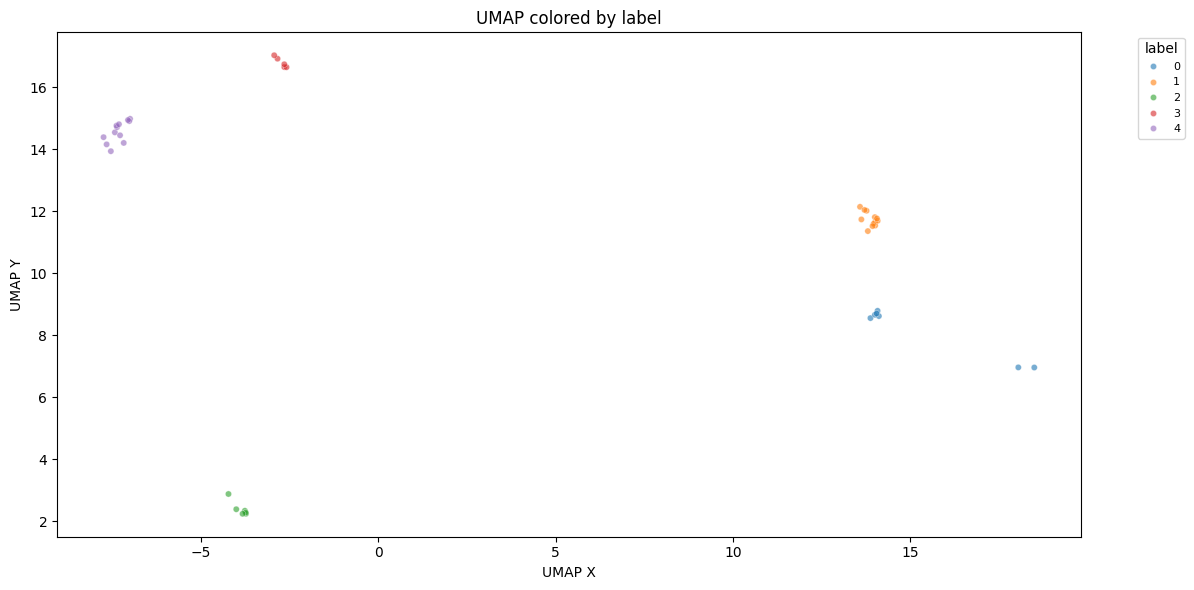

In [17]:
# Visualization 2: Scatterplot colored by conformer type
plt.figure(figsize=(12, 6))

# Filter out Unknown conformers for cleaner visualization
df_plot_type = df_with_torsions_bad.filter(pl.col("conformer_type") != "Unknown")

# Count conformer types to show only those with sufficient data
type_counts = df_plot_type.group_by("conformer_type").agg(pl.count()).sort("conformer_type", descending=True)
print("Conformer types and their counts:")
print(type_counts)

# Create scatterplot
sns.scatterplot(data=df_plot_type.to_pandas(), x='X', y='Y', hue='conformer_type', 
                palette='tab10', alpha=0.6, s=20)
plt.title('UMAP colored by Hexane Conformer Type')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.legend(title='Conformer Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


# Create scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot_type.to_pandas(), x='X', y='Y', hue='label', 
                palette='tab10', alpha=0.6, s=20)
plt.title('UMAP colored by label')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.legend(title='label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [18]:
# Get indices of good torsions from df_with_torsions (exclude "mixed" conformer types)
df_with_torsions_idx = df_with_torsions.with_row_index("row_idx")
good_idx = df_with_torsions_idx.filter(
    ~pl.col("conformer_type").str.to_lowercase().str.contains("mixed")
)["row_idx"].to_numpy()

# Filter cor array using good indices
cor_good = cor[good_idx]

# Filter df_plot_type to exclude Unknown and get labels
df_plot_type = df_with_torsions_good.filter(pl.col("conformer_type") != "Unknown")

for i in df_plot_type["label"].unique():
    # Get indices from df_with_torsions_good where label == i and conformer_type != "Unknown"
    filtered_df = df_with_torsions_good.filter(
        (pl.col("label") == i) & (pl.col("conformer_type") != "Unknown")
    )
    # Get the row indices relative to df_with_torsions_good
    # Since df_with_torsions_good is already filtered by good_idx, we need to map back
    # Get indices in df_with_torsions that match the filtered rows
    df_good_with_idx = df_with_torsions_good.with_row_index("good_row_idx")
    filtered_with_idx = df_good_with_idx.filter(
        (pl.col("label") == i) & (pl.col("conformer_type") != "Unknown")
    )
    good_row_indices = filtered_with_idx["good_row_idx"].to_numpy()
    
    # Use indices to filter cor_good array
    clu0 = cor_good[good_row_indices]
    clu0_center_idx = 0
    clu0_aligned = align_fragments(clu0, clu0_center_idx) # and align all fragments to it
    print(f'Cluster {i} has {len(clu0_aligned)} fragments')
    clu0_view = Fragment.plot_fragments(clu0_aligned)
    display(HTML(clu0_view.write_html(fullpage=True)))


Cluster 0 has 459 fragments


Cluster 1 has 69 fragments


Cluster 2 has 33 fragments


Cluster 3 has 19 fragments


Cluster 4 has 47 fragments


In [19]:
# Get indices of good torsions from df_with_torsions (exclude "mixed" conformer types)
df_with_torsions_idx = df_with_torsions.with_row_index("row_idx")
good_idx = df_with_torsions_idx.filter(
    ~pl.col("conformer_type").str.to_lowercase().str.contains("mixed")
)["row_idx"].to_numpy()

# Filter cor array using good indices
cor_good = cor[good_idx]

# Filter df_plot_type to exclude Unknown and get labels
df_plot_type = df_with_torsions_good.filter(pl.col("conformer_type") != "Unknown")

for i in df_plot_type["label"].unique():
    # Get indices from df_with_torsions_good where label == i and conformer_type != "Unknown"
    filtered_df = df_with_torsions_good.filter(
        (pl.col("label") == i) & (pl.col("conformer_type") != "Unknown")
    )
    # Get the row indices relative to df_with_torsions_good
    # Since df_with_torsions_good is already filtered by good_idx, we need to map back
    # Get indices in df_with_torsions that match the filtered rows
    df_good_with_idx = df_with_torsions_good.with_row_index("good_row_idx")
    filtered_with_idx = df_good_with_idx.filter(
        (pl.col("label") == i) & (pl.col("conformer_type") != "Unknown")
    )
    good_row_indices = filtered_with_idx["good_row_idx"].to_numpy()
    
    # Use indices to filter cor_good array
    clu0 = cor_good[good_row_indices]
    clu0_center_idx = 0
    clu0_aligned = align_fragments(clu0, clu0_center_idx) # and align all fragments to it
    print(f'Cluster {i} has {len(clu0_aligned)} fragments')
    clu0_view = Fragment.plot_fragments(clu0_aligned)
    display(HTML(clu0_view.write_html(fullpage=True)))


Cluster 0 has 459 fragments


Cluster 1 has 69 fragments


Cluster 2 has 33 fragments


Cluster 3 has 19 fragments


Cluster 4 has 47 fragments


In [20]:
# Visualize label 0 and label 1 together in the same HTML with different colors
import numpy as np

# Get indices for label 0
df_good_with_idx = df_with_torsions_good.with_row_index("good_row_idx")
filtered_label0 = df_good_with_idx.filter(
    (pl.col("label") == 0) & (pl.col("conformer_type") != "Unknown")
)
label0_indices = filtered_label0["good_row_idx"].to_numpy()

# Get indices for label 1
filtered_label1 = df_good_with_idx.filter(
    (pl.col("label") == 1) & (pl.col("conformer_type") != "Unknown")
)
label1_indices = filtered_label1["good_row_idx"].to_numpy()

# Get conformers for both labels
clu0 = cor_good[label0_indices]
clu1 = cor_good[label1_indices]

# Concatenate both clusters
clu01 = np.concatenate([clu0, clu1])

# Align all fragments together using the first fragment as center
clu01_center_idx = 0
clu01_aligned = align_fragments(clu01, clu01_center_idx)

print(f'Label 0 has {len(clu0)} fragments')
print(f'Label 1 has {len(clu1)} fragments')
print(f'Total aligned: {len(clu01_aligned)} fragments')

# Create visualization
clu01_view = Fragment.plot_fragments(clu01_aligned)

# Add different colors for label 0 (green) and label 1 (red)
label0_idx = list(range(len(clu0)))
label1_idx = list(range(len(clu0), len(clu01)))

clu01_view.addStyle({'model': label0_idx}, {'line': {'color': 'green'}})
clu01_view.addStyle({'model': label1_idx}, {'line': {'color': 'red'}})

display(HTML(clu01_view.write_html(fullpage=True)))


Label 0 has 459 fragments
Label 1 has 69 fragments
Total aligned: 528 fragments
